<a href="https://colab.research.google.com/github/MayankDey20/Internal_project/blob/main/AI_powered_education_platform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Merged Dataset Details

Number of students taking both courses: 382


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel_por,freetime_por,goout_por,Dalc_por,Walc_por,health_por,absences_por,G1_por,G2_por,G3_por
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


### Model Evaluation

#### Model Accuracy: **71.88%**


#### Classification Report:
              precision    recall  f1-score   support

        Fail       0.67      0.31      0.43        32
        Pass       0.73      0.92      0.81        64

    accuracy                           0.72        96
   macro avg       0.70      0.62      0.62        96
weighted avg       0.71      0.72      0.68        96



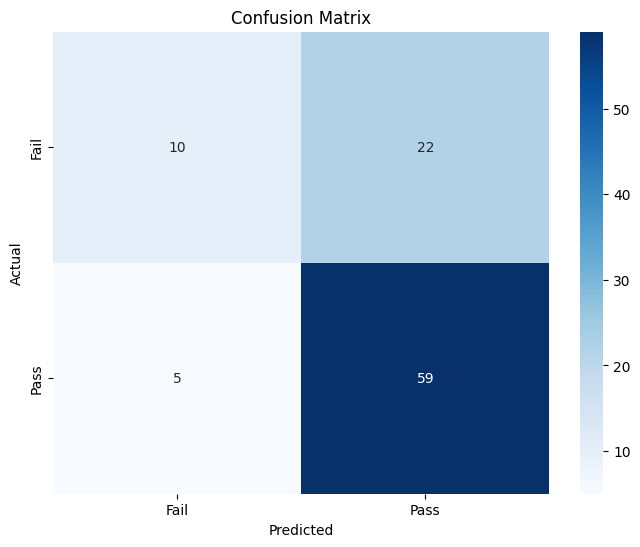

### Top 15 Most Important Features

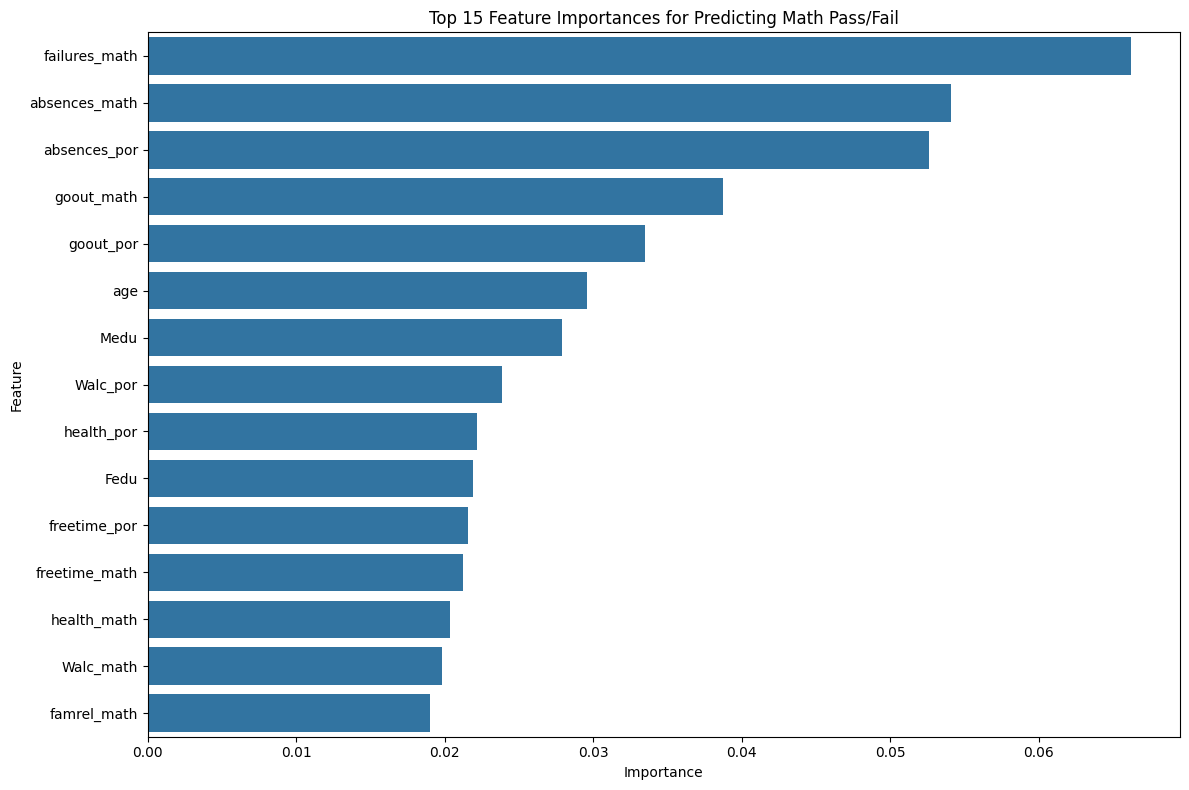

In [3]:
# -*- coding: utf-8 -*-
"""
AIEducationPlatform_RealData.ipynb

Predicting student performance on the Math final exam using a real-world dataset.
"""

## 1. Project Setup
!pip install pandas scikit-learn numpy matplotlib seaborn --quiet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

## 2. Load and Merge the Real Dataset
try:
    # Load the two datasets. The separator is a semicolon.
    df_mat = pd.read_csv('student-mat.csv', sep=';')
    df_por = pd.read_csv('student-por.csv', sep=';')
except FileNotFoundError:
    print("❌ Error: Make sure 'student-mat.csv' and 'student-por.csv' are in the same directory.")
    # Exit if files are not found
    exit()

# Define the columns to merge on, as identified in the data description
merge_keys = ["school", "sex", "age", "address", "famsize", "Pstatus", "Medu", "Fedu",
              "Mjob", "Fjob", "reason", "nursery", "internet"]

# Merge the two dataframes to find students who are in both courses
df_merged = pd.merge(df_mat, df_por, on=merge_keys, suffixes=('_math', '_por'))

display(Markdown(f"### Merged Dataset Details"))
print(f"Number of students taking both courses: {len(df_merged)}")
display(df_merged.head())


## 3. Feature Engineering and Target Definition
# For this task, we will predict pass/fail in the Math course.
# A common threshold for passing is a grade of 10 or higher (out of 20).
# We create a new binary target variable: 1 for Pass, 0 for Fail.
df_merged['passed_math'] = np.where(df_merged['G3_math'] >= 10, 1, 0)

# Define our features (X) and target (y)
# We exclude grade columns (G1, G2, G3) to prevent data leakage,
# as they are direct indicators of the final grade.
# We also drop course-specific features from the Portuguese course.
y = df_merged['passed_math']
X = df_merged.drop(columns=[
    'G1_math', 'G2_math', 'G3_math', 'passed_math',
    'G1_por', 'G2_por', 'G3_por'
])


## 4. Preprocessing Pipeline for Real-World Data
# Identify categorical and numeric features from our selected columns (X)
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=np.number).columns

# Create a preprocessing pipeline
# OneHotEncoder handles categorical data, and StandardScaler scales numeric data.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any (shouldn't be any in this case)
)


## 5. Model Training and Evaluation
# Define the model
model = RandomForestClassifier(n_estimators=150, random_state=42)

# Create the full pipeline by combining the preprocessor and the model
full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', model)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Train the model using the pipeline
full_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = full_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
display(Markdown(f"### Model Evaluation"))
display(Markdown(f"#### Model Accuracy: **{accuracy:.2%}**"))
print("\n#### Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Fail', 'Pass']))

# Display a confusion matrix for better insight
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## 6. Feature Importance
# Extract feature names after one-hot encoding
ohe_feature_names = full_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, ohe_feature_names])

# Get importances from the trained model
importances = full_pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15) # Show top 15 features

display(Markdown("### Top 15 Most Important Features"))
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Top 15 Feature Importances for Predicting Math Pass/Fail')
plt.tight_layout()
plt.show()